In [1]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn import svm
from skimage.feature import greycomatrix, greycoprops
from sklearn import metrics

## Read Data

In [6]:
%run ../Preprocessing/Read_Data.ipynb

886


## Extract Features

In [7]:
def get_glcm_feature(gray_scale_img, name):
    GLCM = greycomatrix(gray_scale_img, distances = [1], angles = [0, np.pi/2, np.pi, np.pi * 1.5 ], levels=256, normed=True)
    # P[i,j,d,theta] is the number of times that grey-level j occurs at a distance d and at an angle theta from grey-level i.
    return np.sum(np.abs(greycoprops(GLCM, prop=name)))
    

In [8]:
# converting the dataset into features (x1, x2)
x_train = np.array([(get_glcm_feature(img, 'energy'), (get_glcm_feature(img, 'homogeneity'))) for img in tqdm(x_train)])
x_test = np.array([(get_glcm_feature(img, 'energy'), (get_glcm_feature(img, 'homogeneity'))) for img in tqdm(x_test)])

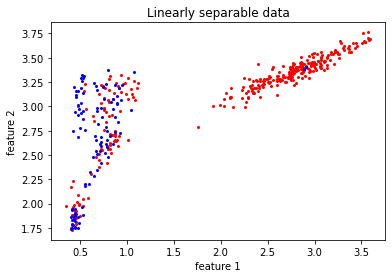

In [9]:
# Generate scatter plot for training data 
x_train_male = x_train[y_train == 0]
x_train_female = x_train[y_train == 1]
plt.scatter(x_train_male[:,0], x_train_male[:,1], color='red', s=4)
plt.scatter(x_train_female[:,0], x_train_female[:,1], color='blue', s=4)
plt.title('Linearly separable data')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.show()
